<a href="https://colab.research.google.com/github/Pritishsingla/Titanic_kaggle/blob/master/Titanic_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tqdm
import sklearn
import datetime
import pickle as pkl
import random
import regex as re
%matplotlib inline

# Loading Data

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Exploration

In [0]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [0]:
train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [0]:
train = train.set_index('PassengerId')
train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


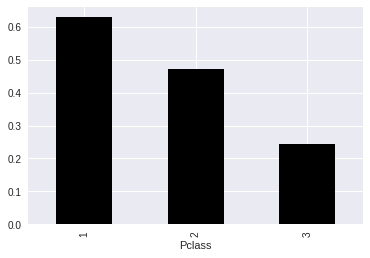

In [0]:
train.groupby(['Pclass']).agg('mean')['Survived'].plot(kind='bar', color='k')

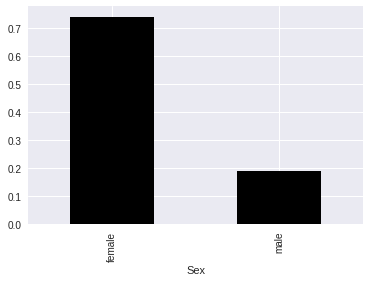

In [0]:
train.groupby(['Sex']).agg('mean')['Survived'].plot(kind='bar', color='k')

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

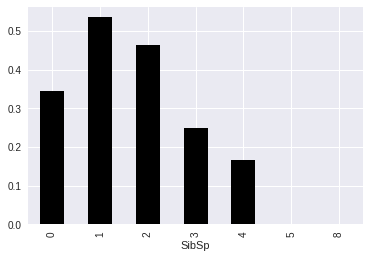

In [0]:
train.groupby('SibSp').agg('mean')['Survived'].plot(kind='bar', color='k')
train.SibSp.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

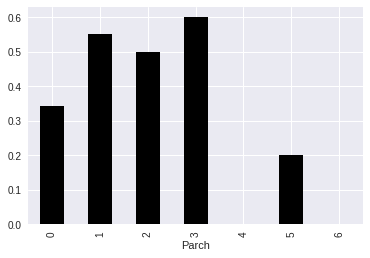

In [0]:
train.groupby('Parch').agg('mean')['Survived'].plot(kind='bar', color='k')
train.Parch.value_counts()# group values

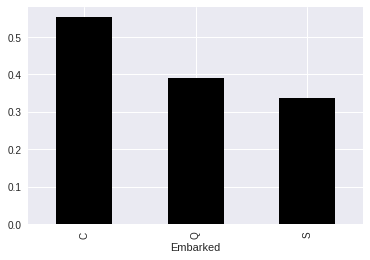

In [0]:
train.groupby('Embarked').agg('mean')['Survived'].plot(kind='bar', color='k')

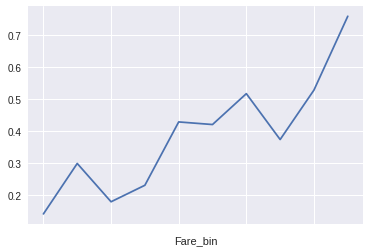

In [0]:
train['Fare_bin'] = pd.qcut(train['Fare'], q=10, labels=range(1, 10+1))
train.groupby('Fare_bin').agg('mean')['Survived'].plot()

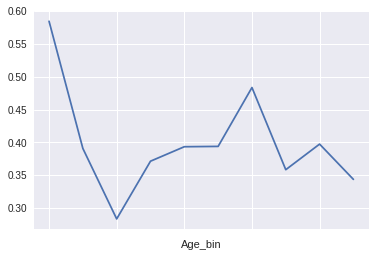

In [0]:
train['Age_bin'] = pd.qcut(train['Age'], q=10, labels=range(1,11))
train.groupby('Age_bin').agg('mean')['Survived'].plot()
train['Child_ind'] = train['Age'] <14.0

0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_2, dtype: int64

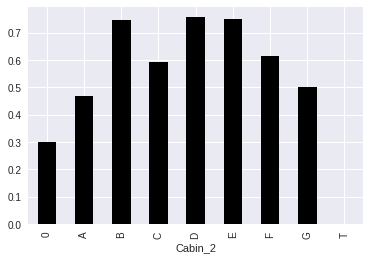

In [0]:
train['Cabin_2'] = train['Cabin'].apply(lambda x: x[0] if type(x)==str else 0)
train.groupby('Cabin_2').agg('mean')['Survived'].plot(kind='bar', color='k')

train.Cabin_2.value_counts()

In [0]:
train['Cabin_2'] = train['Cabin_2'].apply(lambda x: x if x not in ['F', 'G', 'T'] else 'Other')
train['Surname'] = train['Name'].apply(lambda x: x.split(',')[0])
train['Salutation'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0][1:])
train[[ 'Name', 'Surname', 'Salutation']].head()
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Fare_bin', 'Age_bin', 'Child_ind',
       'Cabin_2', 'Surname', 'Salutation'],
      dtype='object')

In [0]:
train['Salutation'].value_counts()
train['Salutation'] = train['Salutation'].apply(lambda x: x if x in ['Mr', 'Miss', 'Master', 'Mrs'] else 'Other' )

train['Name_len'] = train.Name.apply(lambda x: len(x.split(' '))-1)

train['Nickname'] = train['Name'].apply(lambda x : 1 if '(' in x else 0)
train[['Name', 'Name_len', 'Nickname']].head(3)

,Name,Name_len,Nickname
PassengerId,,,
1,"Braund, Mr. Owen Harris",3,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",6,1
3,"Heikkinen, Miss. Laina",2,0


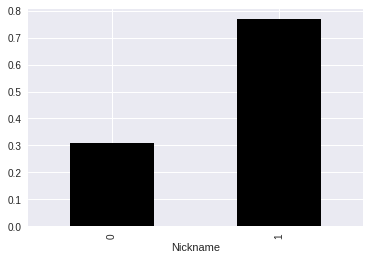

In [0]:
train.groupby('Nickname').agg('mean')['Survived'].plot(kind='bar', color='k')

In [0]:
train.groupby('Salutation').agg('mean')['Age']

Salutation
Master     4.574167
Miss      21.773973
Mr        32.368090
Mrs       35.898148
Other     42.384615
Name: Age, dtype: float64

In [0]:
train['Age_null_ind'] = train.Age.isnull().astype(int)
train['Age_estimated_ind'] = train.Age.apply(lambda x: x%1 >0).astype(int)

In [0]:
train[train.Age < 1]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Fare_bin,Age_bin,Child_ind,Cabin_2,Surname,Salutation,Name_len,Nickname,Age_null_ind,Age_estimated_ind
PassengerId,,,,,,,,,,,,,,,,,,,,,
79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,...,8,1,True,0,Caldwell,Master,3,0,0,1
306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,...,10,1,True,C,Allison,Master,3,0,0,1
470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,...,6,1,True,0,Baclini,Miss,3,0,0,1
645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,...,6,1,True,0,Baclini,Miss,2,0,0,1
756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,...,6,1,True,0,Hamalainen,Master,2,0,0,1
804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,...,4,1,True,0,Thomas,Master,3,0,0,1
832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,...,6,1,True,0,Richards,Master,3,0,0,1


In [0]:
# train[train['Age'].isnull()]

In [0]:
import regex as re
train['ticket_has_letters']  = train['Ticket'].apply(lambda x: bool(re.search('[a-zA-Z]', x)))
train[['ticket_has_letters', 'Ticket']].head()

,ticket_has_letters,Ticket
PassengerId,,
1,True,A/5 21171
2,True,PC 17599
3,True,STON/O2. 3101282
4,False,113803
5,False,373450


In [0]:
train.groupby('ticket_has_letters').agg('mean')['Survived']

ticket_has_letters
False    0.384266
True     0.382609
Name: Survived, dtype: float64

In [0]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Fare_bin', 'Age_bin', 'Child_ind',
       'Cabin_2', 'Surname', 'Salutation', 'Name_len', 'Nickname',
       'Age_null_ind', 'Age_estimated_ind', 'ticket_has_letters'],
      dtype='object')

In [0]:
median_age_salutation = train[~train.Age.isnull()].groupby('Salutation').agg(['median'])['Age']
median_age_salutation

,median
Salutation,
Master,3.5
Miss,21.0
Mr,30.0
Mrs,35.0
Other,44.5


In [0]:
train['Age_imputated'] = train.apply(lambda x: x if x['Age'] == np.nan else median_age_salutation.loc[x['Salutation']], axis=1)
train[train.Age.isnull()][['Salutation', 'Age_imputated']].head()

,Salutation,Age_imputated
PassengerId,,
6,Mr,30.0
18,Mr,30.0
20,Mrs,35.0
27,Mr,30.0
29,Miss,21.0


In [0]:
train[~train.Age.isnull()].groupby('Salutation').agg(['median', 'mean', 'std'])['Age']

,median,mean,std
Salutation,,,
Master,3.5,4.574167,3.619872
Miss,21.0,21.773973,12.990292
Mr,30.0,32.368090,12.708793
Mrs,35.0,35.898148,11.433628
Other,44.5,42.384615,13.200233


In [0]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Fare_bin', 'Age_bin', 'Child_ind',
       'Cabin_2', 'Surname', 'Salutation', 'Name_len', 'Nickname',
       'Age_null_ind', 'Age_estimated_ind', 'ticket_has_letters',
       'Age_imputated'],
      dtype='object')

In [0]:
## outlier treatment

outlier_check_list =['Fare', 'Age_imputated', 'SibSp', 'Parch']

percentile_list=[0, 0.5, 1, 2, 5, 10, 25, 75, 90, 95, 98, 99, 99.5, 100]

outlier_df = pd.DataFrame()

for column in outlier_check_list:
  output_list= []
  for percentile in percentile_list:
    output_list.append({'Percentile': percentile, column:np.percentile(train[column], q=percentile, interpolation='lower') })
    output_df = pd.DataFrame(output_list)
  try:
    outlier_df = pd.merge(outlier_df, output_df, on='Percentile', how='left')
  except:
    outlier_df = output_df
      
outlier_df.set_index('Percentile')

,Fare,Age_imputated,SibSp,Parch
Percentile,,,,
0.0,0.0000,3.5,0,0
0.5,0.0000,3.5,0,0
1.0,0.0000,3.5,0,0
2.0,6.2375,3.5,0,0
5.0,7.2250,21.0,0,0
10.0,7.5500,21.0,0,0
25.0,7.8958,30.0,0,0
75.0,31.0000,30.0,1,0
90.0,77.9583,35.0,1,2


In [0]:
# treating outliers 

train['SibSp_ind'] = train['SibSp'].apply(lambda x: x>1)
train['SibSp_2'] = train['SibSp'].apply(lambda x: x if x<2 else 2)
train['Parch_2'] = train['Parch'].apply(lambda x:  x if x<=2 else 2)

In [0]:
# drop useless columns

def drop_useless_columns(df, columns_list):
  return df.drop(columns=cols_to_drop)



In [0]:
# make dummy varibales

def make_dummies(df, columns_list, drop_first=True):
  return pd.get_dummies(df, columns=columns_list, prefix=categorical_columns, drop_first=drop_first)



In [0]:
# renaming columns
def rename_columns(df):
  for column in df.columns:
    if ']' in column:
      column2 = column[:-1] + ')'
      column2 =  column2.replace(', ', '')
#       print(column2)
      df.rename(columns={column:column2}, inplace=True)
  return df


In [0]:
def encode_data(dataset_train, cols_to_encode=['Sex', 'Embarked', 'Salutation', 'Cabin_2', 'ticket_initials']):
  # Encoding String values to Numbers
  from sklearn.preprocessing import LabelEncoder
  for col in cols_to_encode:
 
    lb = LabelEncoder()
    dataset_train[col] = lb.fit_transform(dataset_train[col])
    
  return dataset_train

In [0]:
categorical_columns = ['Sex', 'Pclass', 'Embarked', 'Cabin_2', 'Salutation', 'Age_bin', 'Fare_bin', 'ticket_initials']
target_col='Survived'
cols_to_drop = ['Name', 'Ticket', 'Cabin', 'Surname', 'Age', 'Fare', 'SibSp', 'Parch_2']
# pd.get_dummies(train, columns=categorical_columns, prefix=categorical_columns, drop_first=1).head()

# Data Preparation

In [220]:
def prepare_data(df):
  
  df = df.set_index('PassengerId')
 
  #cabin
  df['Cabin_2'] = df['Cabin'].apply(lambda x: x[0] if type(x)==str else 'ZZ')
  df['Cabin_2'] = df['Cabin_2'].apply(lambda x: x if x not in ['F', 'G', 'T'] else 'Other')
  
  #name
  df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])
  df['Salutation'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0][1:])
  df['Salutation'] = df['Salutation'].apply(lambda x: x if x in ['Mr', 'Miss', 'Master', 'Mrs'] else 'Other' )
  df['Name_len'] = df.Name.apply(lambda x: len(x.split(' '))-1)
  df['Nickname'] = df['Name'].apply(lambda x : 1 if '(' in x else 0)
  
  #age
  df['Age_null_ind'] = df.Age.isnull().astype(int)
  df['Age_estimated_ind'] = df.Age.apply(lambda x: x%1 >0).astype(int)
  df['Age_imputated'] = df.apply(lambda x: x if x['Age'] == np.nan else median_age_salutation.loc[x['Salutation']], axis=1)# missing value
  df['Child_ind'] = df['Age_imputated'].apply(lambda x: 1 if x <14.0 else 0)
#   df['Age_bin'] = pd.qcut(df['Age_imputated'], q=8, labels=range(1,11), duplicates='drop')
  
  # family
  df['family'] = df['SibSp'] + df['Parch']
  
   # alone
  df['is_alone'] = (df.family ==0).astype(int)
  
  #embarked
  df['Embarked'] = df['Embarked'].fillna('S')
  
  # fare
  df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
  df['Fare_bin'] = pd.qcut(df['Fare'], q=10, labels=range(1, 10+1))
  
  # ticket
  df['ticket_initials']  = df['Ticket'].apply(lambda x: str(x)[0])
  df['ticket_initials']  = df['ticket_initials'].apply(lambda x: re.sub('[0-9]', 'N', x))
  df['ticket_initials']  = df['ticket_initials'].apply(lambda x: x if x not in ['F', 'L', 'W'] else 'Z')
  
  # new_variable
  df['age_class'] = df['Age_imputated']*df['Pclass']
  
  # outliers
  df['SibSp_ind'] = df['SibSp'].apply(lambda x: x>1).astype(int)
  df['SibSp_2'] = df['SibSp'].apply(lambda x: x if x<2 else 2)
  df['Parch_2'] = df['Parch'].apply(lambda x:  x if x<=2 else 2)
  
  # drop columns
  df_data = drop_useless_columns(df, columns_list=cols_to_drop)

  # dummies
#   df_data = make_dummies(df_data, categorical_columns)

  # encode: 
  df_data = encode_data(df_data)
  
  # rename columns
  df_data = rename_columns(df_data)
  
  return df_data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test_data = prepare_data(test)
train_data = prepare_data(train)
print(test_data.shape, train_data.shape) 
  
  

(418, 19) (891, 20)


In [221]:
train_data['is_alone' ].value_counts()

1    537
0    354
Name: is_alone, dtype: int64

In [222]:
# make train validation split
from sklearn.model_selection import train_test_split
train_xy, validation_xy = train_test_split(train_data, test_size=0.15, shuffle=True, random_state=1)
train_xy.shape, validation_xy.shape


((757, 20), (134, 20))

In [223]:
def get_features_labels(df, targete_col='Survived'):
  return df.drop(columns=[target_col]), df[target_col]

x_train, y_train = get_features_labels(train_xy)
x_vali, y_vali = get_features_labels(validation_xy)
x_train.shape, x_vali.shape

((757, 19), (134, 19))

In [0]:
train_xy.columns

Index(['Survived', 'Pclass', 'Sex', 'Parch', 'Embarked', 'Cabin_2',
       'Salutation', 'Name_len', 'Nickname', 'Age_null_ind',
       'Age_estimated_ind', 'Age_imputated', 'Child_ind', 'family', 'is_alone',
       'Fare_bin', 'ticket_initials', 'age_class', 'SibSp_ind', 'SibSp_2'],
      dtype='object')

# Logistic Regression

In [0]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics

formula = target_col + ' ~ ' + ' + '.join(train_xy.columns[1:])
# print(formula)


def train_logistic_model(data, formula=formula, summary=True):
  model = smf.glm(formula=formula, data=data,family=sm.families.Binomial()).fit()
  print('Train ROC AUC: ', metrics.roc_auc_score(y_train, model.predict(x_train)), \
      '|| Validation ROC AUC: ', metrics.roc_auc_score(y_vali, model.predict(x_vali)))
  if summary:
    print(model.summary())
  return model

model = train_logistic_model(data=train_xy, summary=False)

Train ROC AUC:  0.8916875991538867 || Validation ROC AUC:  0.7927078021417644


In [0]:
formula

'Survived ~ Parch + Name_len + Nickname + Child_ind + Age_null_ind + Age_estimated_ind + Age_imputated + relatives + ticket_has_letters + age_class + SibSp_ind + SibSp_2 + Sex_male + Pclass_2 + Pclass_3 + Embarked_Q + Embarked_S + Cabin_2_A + Cabin_2_B + Cabin_2_C + Cabin_2_D + Cabin_2_E + Cabin_2_Other + Salutation_Miss + Salutation_Mr + Salutation_Mrs + Salutation_Other + Age_bin_2 + Age_bin_3 + Age_bin_4 + Age_bin_5 + Age_bin_6 + Age_bin_7 + Age_bin_8 + Age_bin_9 + Age_bin_10 + Fare_bin_2 + Fare_bin_3 + Fare_bin_4 + Fare_bin_5 + Fare_bin_6 + Fare_bin_7 + Fare_bin_8 + Fare_bin_9 + Fare_bin_10'

In [0]:
# Backward Selection

def backward_selection(df, formula, threshold=0.05):
  flag=0
  while flag==0:
    func = smf.glm(formula =formula, data=df, family = sm.families.Binomial()).fit()
    pvals = pd.DataFrame(func.pvalues, columns=['pval'])
    pvals['varname'] = [i.split('[')[0] for i in pvals.index]
    pvals = pd.DataFrame(pvals.groupby(['varname'])['pval'].min())
    pvals = pvals.drop(['Intercept'])
    if max(pvals['pval']) < threshold:
      flag=1
      break
    else:
      var_to_rem = pvals.sort_values('pval', ascending=False).index[0].split('[')[0]
#       print(max(pvals['pval']))
      if '+ ' + var_to_rem + ' +' in formula:
        formula = formula.replace('+ ' + var_to_rem + ' +', '+')
      elif '~ ' + var_to_rem in formula:
        formula = formula.replace('~ ' + var_to_rem, '~ ')
      elif '+ ' + var_to_rem in formula:
        formula = formula.replace('+ ' + var_to_rem, '')
      print('Variable removed: ', var_to_rem)
      
      
  return formula
    
formula_new = backward_selection(train_xy, formula)
formula_new

Variable removed:  Salutation_Mr
Variable removed:  Salutation_Mrs
Variable removed:  Age_bin_5
Variable removed:  Age_bin_4
Variable removed:  Age_bin_6
Variable removed:  Name_len
Variable removed:  Fare_bin_8
Variable removed:  Age_estimated_ind
Variable removed:  Age_bin_8
Variable removed:  Age_bin_3
Variable removed:  Age_null_ind
Variable removed:  ticket_has_letters
Variable removed:  Fare_bin_4
Variable removed:  Fare_bin_5
Variable removed:  Fare_bin_6
Variable removed:  Age_bin_9
Variable removed:  Age_bin_10
Variable removed:  Cabin_2_C
Variable removed:  SibSp_2
Variable removed:  Cabin_2_Other
Variable removed:  Embarked_Q
Variable removed:  Cabin_2_A
Variable removed:  Cabin_2_B
Variable removed:  Fare_bin_7
Variable removed:  Fare_bin_9
Variable removed:  Fare_bin_10
Variable removed:  Age_bin_2
Variable removed:  age_class
Variable removed:  Nickname
Variable removed:  Fare_bin_2
Variable removed:  Child_ind


'Survived ~ Parch + Age_imputated + relatives + SibSp_ind + Sex_male + Pclass_2 + Pclass_3 + Embarked_S + Cabin_2_D + Cabin_2_E + Salutation_Miss + Salutation_Other + Age_bin_7 + Fare_bin_3 '

In [0]:
# training after backward selection
model = train_logistic_model(data=train_xy, formula=formula_new)

Train ROC AUC:  0.8848658117398202 || Validation ROC AUC:  0.7944926058133605
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  801
Model:                            GLM   Df Residuals:                      787
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -315.32
Date:                Sun, 25 Nov 2018   Deviance:                       630.63
Time:                        10:48:45   Pearson chi2:                     872.
No. Iterations:                     6                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2426      0.428

In [0]:
test_pred = pd.DataFrame(model.predict(test_data), 
test_submit_logistic = pd.DataFrame()

In [0]:
#VIF

def make_vif(form, data=train_xy):
  vif_list = [i for i in form.params.index[1: ] if 'C(']

# SVM

In [252]:
##SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# grid search

def svc_param_selection(X, y, nfolds):
    print('Hyparameter Tuning using Grid SEarch')
    kernels =['linear', 'rbf']
    Cs = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, ]
    gammas = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 10, 'auto']
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernels}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search
  

grid_search = svc_param_selection(x_train, y_train, nfolds=5)
print('Best Parameters: ', grid_search.best_params_)

print('#####################################\n')

svm_clf = grid_search.best_estimator_

pd.DataFrame.from_dict(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'mean_train_score']].sort_values(by='mean_test_score', ascending=False).head()*100

# print('#####################################\n')
# print('Train_Accuracy: ', np.round(svm_clf.score(x_train, y_train)*100,2), ' %')
# print('Validation_Accuracy: ', np.round(svm_clf.score(x_vali, y_vali)*100,2), ' %')


# print('\nTrain ROC AUC: ', metrics.roc_auc_score(y_train, svm_clf.predict_proba(x_train)[:,1]), \
#       '|| Validation ROC AUC: ', metrics.roc_auc_score(y_vali, svm_clf.predict_proba(x_vali)[:, 1]))

Hyparameter Tuning using Grid SEarch
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:  1.8min


Best Parameters:  {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
#####################################



[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.4min finished


,mean_test_score,std_test_score,mean_train_score
83,83.091149,2.290136,84.049079
111,83.091149,2.277973,88.705876
79,82.959049,1.962746,84.742585
69,82.959049,2.126438,84.247099
129,82.959049,1.962746,84.312996


In [254]:
svm_clf

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [255]:
test_pred = pd.DataFrame(svm_clf.predict(test_data), columns=['Survived'])
test_pred['PassengerId'] = test_data.index
test_submit_svm = test_pred.copy(deep=True)
test_submit_svm = test_submit_svm[['PassengerId', 'Survived']]
test_submit_svm = test_submit_svm.set_index('PassengerId')
test_submit_svm.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [0]:
test_submit_svm.to_csv('test_svm_5.csv')

# Random Forests

In [246]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'criterion' :['entropy', 'gini'],
    'max_depth': [3,5,8,10,15],
    'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 15, 20, 25, 50, 100]
}
# Create a based model
random_forest = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 0, )


# Fit the grid search to the data
print(train_data.shape)
grid_search.fit(train_data.iloc[:, 1:], train_data.iloc[:,0])
best_params_rf = grid_search.best_params_
random_forest = grid_search.best_estimator_
best_score = grid_search.best_score_
print('Best Parameters: ', best_params_rf)

pd.DataFrame.from_dict(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'mean_train_score']].sort_values(by='mean_test_score', ascending=False).head()*100
# grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']
# print('#####################################\n')
# print('Train_Accuracy: ', np.round(random_forest.score(x_train, y_train)*100,2), ' %')
# print('Validation_Accuracy: ', np.round(random_forest.score(x_vali, y_vali)*100,2), ' %')


# print('\nTrain ROC AUC: ', metrics.roc_auc_score(y_train, random_forest.predict_proba(x_train)[:,1]), \
#       '|| Validation ROC AUC: ', metrics.roc_auc_score(y_vali, random_forest.predict_proba(x_vali)[:, 1]))

(891, 20)
Best Parameters:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 25}


,mean_test_score,std_test_score,mean_train_score
27,83.277217,1.778424,85.634630
120,83.052750,2.186000,85.213637
114,83.052750,2.162427,85.129249
125,83.052750,1.359629,85.494102
101,83.052750,2.608954,83.754261


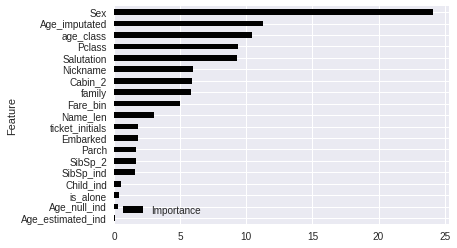

In [247]:
features = train_data.columns[1: ]
importances = random_forest.feature_importances_
imp_df = pd.DataFrame()
imp_df['Feature'] = features
imp_df['Importance'] = np.round(importances*100,1)
imp_df.sort_values(by='Importance', ascending=1).set_index('Feature').plot(kind='barh', color='k')

In [244]:
test_pred = pd.DataFrame(random_forest.predict(test_data), columns=['Survived'])
test_pred['PassengerId'] = test_data.index
test_submit_rf = test_pred.copy(deep=True)
test_submit_rf = test_submit_rf[['PassengerId', 'Survived']]
# test_submit_svm = test_submit_svm.reset_index()
test_submit_rf = test_submit_rf.set_index('PassengerId')
test_submit_rf.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [0]:
test_submit_rf.to_csv('test_rf_4.csv')

# XgBoost

In [270]:
import xgboost

# Create the parameter grid based on the results of random search 
param_grid = {
#     'bootstrap': [True],
#     'criterion' :['entropy', 'gini'],
    'max_depth': [3,5,10,15],
    'colsample_bytree' :[0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 25, 50, 100],
    'gamma': [0,1,5],
}
# Create a based model
xgb = xgboost.XGBClassifier(n_jobs=-1, random_state=3, )
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 1, )


# Fit the grid search to the data
train_x = np.array(train_data.drop(columns=['Survived']))
print(train_x.shape)
grid_search.fit(train_x, train_data['Survived'])
best_params_xgb = grid_search.best_params_
xgb = grid_search.best_estimator_
best_score = grid_search.best_score_
print('Best Parameters: ', best_params_xgb)

pd.DataFrame.from_dict(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'mean_train_score']].sort_values(by='mean_test_score', ascending=False).head()*100

(891, 19)
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2060 tasks      | elapsed:  1.0min


Best Parameters:  {'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.1min finished


,mean_test_score,std_test_score,mean_train_score
506,83.838384,1.760822,89.815103
687,83.501684,1.493734,89.871164
631,83.501684,2.760349,90.095530
679,83.501684,2.145012,87.261640
699,83.501684,1.893003,89.730873


In [271]:
test_pred = pd.DataFrame(xgb.predict(np.array(test_data)), columns=['Survived'])
test_pred['PassengerId'] = test_data.index
test_submit_xgb = test_pred.copy(deep=True)
test_submit_xgb = test_submit_xgb[['PassengerId', 'Survived']]
# test_submit_svm = test_submit_svm.reset_index()
test_submit_xgb = test_submit_xgb.set_index('PassengerId')
test_submit_xgb.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [0]:
test_submit_xgb.to_csv('test_xgb.csv')